# Extracting texts

In [17]:
import pandas as pd
import numpy as np
import pickle

file_path = "/mnt/nas/cinus/SocialAIGym/data/raw/Brexit/processed_tweet_and_retweet_data.pkl"
columns_to_select = [
    'author_id_ORIGINAL', 'id_ORIGINAL', 'text_ORIGINAL',
    'author_id_RETWEET', 'id_RETWEET', 'text_RETWEET'
]

def load_selected_columns(file_path, columns):
    # Read the entire dataframe first
    df = pd.read_pickle(file_path)
    # Select the specified columns and ensure all are strings
    df_selected = df[columns].astype(str)
    return df_selected

df_selected = load_selected_columns(file_path, columns_to_select)
df_selected = df_selected.reset_index()

display(df_selected.head())


,index,author_id_ORIGINAL,id_ORIGINAL,text_ORIGINAL,author_id_RETWEET,id_RETWEET,text_RETWEET
0,0,201664833,755343961233977344,My 81 year old dad has signed up as a register...,330543773,755439263387443200,RT @mathewhbenham: My 81 year old dad has sign...
1,1,201664833,745702715272077312,Beep! Beep! The car is ready for tomorrow. We ...,19081463,745763604851531776,RT @mathewhbenham: Beep! Beep! The car is read...
2,2,201664833,745337739126673408,@SadiqKhan has just owned @GiselaStuart big ti...,22186521,745338438250016768,RT @mathewhbenham: @SadiqKhan has just owned @...
3,3,201664833,745332404882186240,Great opening speech by @SadiqKhan A #voterema...,265281570,745332908286676992,RT @mathewhbenham: Great opening speech by @Sa...
4,4,201664833,744921630967730176,Our cat loves Gourmet Cat Food. #CatsAgainstBr...,340924056,744976903665233920,RT @mathewhbenham: Our cat loves Gourmet Cat F...


In [18]:
import pickle

with open("/mnt/nas/cinus/SocialAIGym/data/raw/Brexit/brexit_07_tweets_ids.pkl", "rb") as file_handle:
    tweet_ids = pickle.load(file_handle)

print(f"Available texts: {len(set(tweet_ids)) - len(set(tweet_ids).difference(set(df_selected['id_ORIGINAL'].unique()))):_} / {len(set(tweet_ids)):_}")



Available texts: 19_960 / 19_960


In [19]:
len(tweet_ids)

19960

In [20]:
import pickle

with open("/mnt/nas/cinus/SocialAIGym/data/raw/Brexit/brexit_07_propagations_and_polarities.pkl", "rb") as file_handle:
    propagations, polarities = pickle.load(file_handle) # propagations are ordered by time (first active --> last active)

print(f"Available propagations: {len(propagations):_}")


Available propagations: 19_960


In [21]:
# tweet_pop = list(map(lambda x: len(x), propagations))

# compute tweet pop from the dataframe
# Compute the number of retweets for each original tweet
retweet_counts = df_selected['id_ORIGINAL'].value_counts().reset_index()
retweet_counts.columns = ['id_ORIGINAL', 'retweet_count']

# Filter out tweets with less than 5 retweets
min_retweets = 5
filtered_retweets = retweet_counts[retweet_counts['retweet_count'] >= min_retweets]

import numpy as np
print('Popularity stats from propagation list:')
# print('Mean pop: ', np.mean(tweet_pop))
# print('std pop: ', np.std(tweet_pop))
# print('Min pop: ', np.min(tweet_pop))
# print('Max pop: ', np.max(tweet_pop))
# print('---')
print('Popularity stats from dataframe:')
print('Mean pop: ', np.mean(filtered_retweets['retweet_count']))
print('std pop: ', np.std(filtered_retweets['retweet_count']))
print('Min pop: ', np.min(filtered_retweets['retweet_count']))
print('Max pop: ', np.max(filtered_retweets['retweet_count']))



Popularity stats from propagation list:
Popularity stats from dataframe:
Mean pop:  11.64455947374097
std pop:  20.34021660455174
Min pop:  5
Max pop:  870


In [22]:
userFeat = pd.read_csv('/mnt/nas/cinus/SocialAIGym/data/raw/Brexit/df_user_features.csv')
with open("/mnt/nas/cinus/SocialAIGym/data/raw/Brexit/brexit_07_username2index.pkl", "rb") as file_handle:
    user2index = pickle.load(file_handle) # propagations are ordered by time (first active --> last active)


In [23]:
mapAuthorId2Node = {}
userId_not_present_in_the_graph = list()

for rowId, row in userFeat[['user_id', 'username']].iterrows():
    if row['username'] in user2index:
        mapAuthorId2Node[row['user_id']] = user2index[row['username']]
    else:
        userId_not_present_in_the_graph.append(row['user_id'])
        

-------

## Compute the number of retweets for each original tweet

## Plot the histogram of the number of retweets

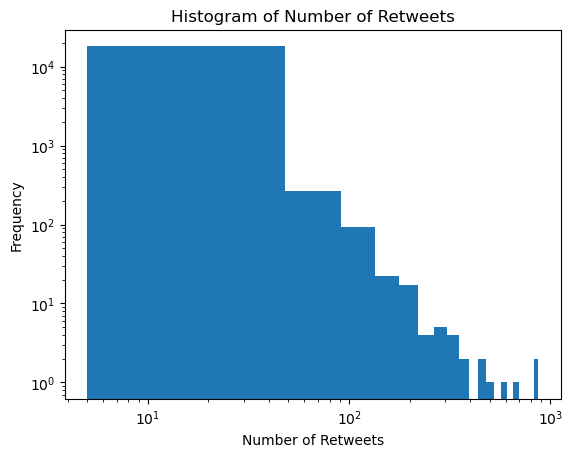

In [24]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(filtered_retweets['retweet_count'], bins=20)
plt.xlabel('Number of Retweets')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Histogram of Number of Retweets')
plt.show()


# Import Stance Classifier (Skip if running more than once)

In [12]:
from transformers import pipeline
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)


## Create network and information diffusion model (Skip if running more than once)

In [25]:
import networkx as nx
import pickle
import numpy as np
from pathlib import Path
import pandas as pd
import os

import sys
sys.path.append("../src")
from data_component import DataComponent
from information_diffusion_component import BoundedConfidenceDiffusionComponent
from graph_utils import *

data = DataComponent(real_data="Brexit")
data.pre_compute_neighboring()
epsilon = 0.2
mu = 0.5
bc_model = BoundedConfidenceDiffusionComponent(data_component=data, epsilon=epsilon, mu=mu)


## Clean the text and compute the stance (Skip if running more than once)


In [30]:
import re
import emoji

# Join with original DataFrame to get the text of original tweets
filtered_retweets = filtered_retweets.merge(df_selected[['id_ORIGINAL', 'text_ORIGINAL']], on='id_ORIGINAL', how='left')
# Remove duplicates
filtered_retweets = filtered_retweets.drop_duplicates(subset=['id_ORIGINAL'])

# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = emoji.replace_emoji(text, replace='')  # Remove emojis
    return text


# Function to compute stance for each text
def compute_stance(text):
    sentiment_outputs = sentiment_model([])
    messages_values = [output["score"] if output["label"] == "POSITIVE" else 1 - output["score"]
                                       for output in sentiment_outputs]

print('Cleaning tweet texts...')
filtered_retweets['cleaned_text'] = filtered_retweets['text_ORIGINAL'].apply(clean_text)
filtered_retweets = filtered_retweets[filtered_retweets['cleaned_text'].str.len() >= 5]
print('Number of tweets: ', len(filtered_retweets.index))
print('Computing stance of tweet texts...')
sentiment_outputs = classifier(filtered_retweets['cleaned_text'].values.tolist())
filtered_retweets['stance'] = [output["score"] if output["label"] == "POSITIVE" else 1 - output["score"] for output in sentiment_outputs]
print('DONE')

filtered_retweets.to_csv('tweet2sentiment.csv')


Cleaning tweet texts...
Number of tweets:  18414
Computing stance of tweet texts...
DONE


## Estimate the number of activated users (Skip if run more than once)

In [31]:
# filtered_retweets = pd.read_csv('tweet2sentiment.csv', lineterminator='\n', index_col=0) 
import sys
sys.path.append("../src")
from data_component import DataComponent
from information_diffusion_component import BoundedConfidenceDiffusionComponent
from graph_utils import *

data = DataComponent(real_data="Brexit")
data.pre_compute_neighboring()

def estimate_activated_users(row, epsilon):
    # epsilon = 0.2
    mu = 0.5
    bc_model = BoundedConfidenceDiffusionComponent(data_component=data, epsilon=epsilon, mu=mu)

    author_id = np.int64(df_selected[df_selected['id_ORIGINAL'] == row['id_ORIGINAL']]['author_id_ORIGINAL'].values[0])
    node_id = mapAuthorId2Node.get(author_id)
    if node_id:
        return bc_model.propagate_message(message=row['stance'], node_id=node_id)[1]
    return None

epsilon2numActivated = {}

for epsilon in [0.2, ]:  # [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]:
    print(f'epsilon: {epsilon}...')
    # estimated_activated_users_list = list()
    # for rowid, row in filtered_retweets.iterrows():
        # epsilon = 0.2
    #     mu = 0.5
    #     bc_model = BoundedConfidenceDiffusionComponent(data_component=data, epsilon=epsilon, mu=mu)
    #     author_id = np.int64(df_selected[df_selected['id_ORIGINAL'] == row['id_ORIGINAL']]['author_id_ORIGINAL'].values[0])
    #     node_id = mapAuthorId2Node.get(author_id)
    #     val=None
    #     if node_id:
    #         val= bc_model.propagate_message(message=row['stance'], node_id=node_id)[1]
    #     estimated_activated_users_list.append(val)
    filtered_retweets['estimated_activated_users'] = filtered_retweets.apply(lambda x: estimate_activated_users(x, epsilon=epsilon), axis=1)
    filtered_retweets.to_csv(f'retweet2BCM_eps{epsilon}.csv')
    epsilon2numActivated[epsilon] = filtered_retweets.copy()

print(filtered_retweets.head())

import pickle
with open('eps2numActivated_SENTIMENT.pkl', 'wb') as file:
    pickle.dump(epsilon2numActivated, file)


epsilon: 0.2...
             id_ORIGINAL  retweet_count  \
0     744579270731718656            870   
870   738764289192910848            833   
1703  743789791624445953            676   
2379  741429682738999296            597   
2976  745396716661248000            493   

                                          text_ORIGINAL  \
0     Guess who Egyptian Media blame for terror atta...   
870   You had one job. One job. https://t.co/bYeqKdGMBC   
1703  Found this clip I filmed of One Direction #1D ...   
2379  Here are 2 billionaires. 1 pays his UK taxes &...   
2976  Dear Race-baiter Remainers\n\nI'm bullish on B...   

                                           cleaned_text    stance  \
0     Guess who Egyptian Media blame for terror atta...  0.231304   
870                          You had one job. One job.   0.237128   
1703  Found this clip I filmed of One Direction #1D ...  0.848142   
2379  Here are 2 billionaires. 1 pays his UK taxes &...  0.336234   
2976  Dear Race-baiter Re

In [33]:
print('DONE')

DONE


## Display real viral tweets

In [ ]:
filtered_retweets = pd.read_csv(f'/mnt/nas/minici/SocialAIGym/notebooks/retweet2BCM_eps{0.2}.csv', 
                                lineterminator='\n', index_col=0) 


In [34]:
filtered_retweets[filtered_retweets['stance'] < 0.5].sort_values(by=['estimated_activated_users'], ascending=False).head(50)



,id_ORIGINAL,retweet_count,text_ORIGINAL,cleaned_text,stance,estimated_activated_users
189844,738843144234668032,6,The EU in a nutshell: https://t.co/aLBlGeRb0V,The EU in a nutshell:,0.198387,2703.0
105701,755744240882311168,14,Makes people uncomfortable here in same way as...,Makes people uncomfortable here in same way as...,0.199736,2703.0
195720,751706289890287616,5,Anger as Labour MP tells Government: Let's kee...,Anger as Labour MP tells Government: Let's kee...,0.198005,2702.0
175006,741770636490645504,6,More migrants rescued off UK coast by border c...,More migrants rescued off UK coast by border c...,0.198311,2702.0
202635,742779066944749570,5,French policing of #EURO2016 is farcical &amp;...,French policing of #EURO2016 is farcical &amp;...,0.197878,2702.0
206670,738818191699398657,5,#InOrOut The EU is NOT a #democracy! How much ...,#InOrOut The EU is NOT a #democracy! How much ...,0.197111,2702.0
211105,741032960531517440,5,Izzard is a complete child and should not be o...,Izzard is a complete child and should not be o...,0.197435,2701.0
170554,751179630858661888,7,See Question time still doesn't get the Leave ...,See Question time still doesn't get the Leave ...,0.192927,2701.0
95724,744595326208720896,16,The case for Remain: Dave on youth unemploymen...,The case for Remain: Dave on youth unemploymen...,0.193143,2701.0
193555,751714997206654977,5,The destruction of Andrea Leadsom: is it no lo...,The destruction of Andrea Leadsom: is it no lo...,0.198329,2701.0


In [42]:
for t in filtered_retweets[filtered_retweets['stance'] < 0.5].sort_values(by=['estimated_activated_users'], ascending=False).head(100).text_ORIGINAL:
    print()
    print(t)




The EU in a nutshell: https://t.co/aLBlGeRb0V

Makes people uncomfortable here in same way as a Boob tube and mini skirt in their countries. We tolerate they don't https://t.co/f2GiWg0yJj

Anger as Labour MP tells Government: Let's keep accepting refugees until Britain BREAKS https://t.co/PXjoqopgRV Off her rocker.

More migrants rescued off UK coast by border chiefs after dinghy sinks https://t.co/Tm5EjLaDeN #VoteLeave

French policing of #EURO2016 is farcical &amp; dangerous. Trouble already in #Lille ... no police to be seen. Eng &amp; Wales under attack again.

#InOrOut The EU is NOT a #democracy! How much more schooling do people need to understand that?

Izzard is a complete child and should not be on the programme  #bbcqt https://t.co/tnMwYGj6Pg

See Question time still doesn't get the Leave vote. Coming a little unstuck. Well done fellas speaking up🇬🇧🇬🇧🇬🇧 https://t.co/ymjdYGXwY1

The case for Remain: Dave on youth unemployment. #questionttime #Brexit #VoteLeave https://t.co/d8

In [38]:
filtered_retweets[filtered_retweets['stance'] > 0.5].sort_values(by=['estimated_activated_users'], ascending=False).head(75)



,id_ORIGINAL,retweet_count,text_ORIGINAL,cleaned_text,stance,estimated_activated_users
168139,740503335946616832,7,You can still register to vote. If you still h...,You can still register to vote. If you still h...,0.808265,3742.0
184144,746042959490080769,6,After many months - the 3 hour countdown is on...,After many months - the 3 hour countdown is on...,0.800428,3742.0
176998,740943354242945024,6,Voter registration has been extended and close...,Voter registration has been extended and close...,0.802583,3740.0
111939,731497472456073216,13,Communities coming together in #Handsworth are...,Communities coming together in #Handsworth are...,0.804398,3740.0
198050,737941124019572737,5,An open hustings organised by Huntly Business ...,An open hustings organised by Huntly Business ...,0.803247,3740.0
...,...,...,...,...,...,...
68009,752521294386761728,26,One of @UKIP’s biggest donors @Arron_banks has...,One of @UKIP’s biggest donors @Arron_banks has...,0.803943,3736.0
166774,749705533570052096,7,There is a petition to have him removed as an ...,There is a petition to have him removed as an ...,0.805723,3736.0
160005,745852614840049665,7,Today is #EUref Polling Day\nPolls open @ 7am ...,Today is #EUref Polling Day\nPolls open @ 7am ...,0.803391,3736.0
163743,741294109823016964,7,I prefer this one... @stephenkb\n#VoteLeave #B...,I prefer this one... @stephenkb\n#VoteLeave #B...,0.806267,3736.0


In [44]:
for t in filtered_retweets[filtered_retweets['stance'] > 0.5].sort_values(by=['estimated_activated_users'], ascending=False).head(200).text_ORIGINAL:
    print()
    print(t)




You can still register to vote. If you still haven't, beat the crowds this time and register right now! #EURef https://t.co/YnMB92j3sh

After many months - the 3 hour countdown is on! Anyone you need to ring, text, call, tweet? Best do it now! #PhoneAFriend #Remain #EUref

Voter registration has been extended and closes today. Don’t miss out: https://t.co/SzguSYUaqi #StrongerIn

Communities coming together in #Handsworth area of #Birmingham to campaign for #StrongerIn &amp; secure a remain vote. https://t.co/yRGT4sGCap

An open hustings organised by Huntly Business Association. Doors open 7pm https://t.co/YhH3t9lJo0 #EUref #StrongerIN https://t.co/IAQ6Hs2vPJ

The Scotch Whisky Association believes we are #StrongerIn https://t.co/cBfUycvsMe #gms https://t.co/5mrAY7JlOB

Boris has spent the last few weeks touring the UK using completely made-up facts. #BBCDebate https://t.co/SlAIeahjM1

Our #Kidderminster volunteers busy in the town reminding people we're #StrongerIn the #Eu. https://t.

In [84]:
text='#InOrOut Remember '
for rowId, row in filtered_retweets[filtered_retweets['stance'] < 0.5].iterrows():
    if text in row['text_ORIGINAL']:
        print(row['text_ORIGINAL'], row.estimated_activated_users)
        break



#InOrOut Remember when we were students &amp; worked weekends &amp; hols. Now we're flooded with EU low skilled migrants.Our kids don't stand chance 2700.0


In [68]:
row

id_ORIGINAL                                                 731805579811815425
retweet_count                                                                5
text_ORIGINAL                Tell us about the alleged conversation with Di...
cleaned_text                 Tell us about the alleged conversation with Di...
stance                                                                0.823984
estimated_activated_users                                               3717.0
Name: 215955, dtype: object

## Display results with standard regression

             id_ORIGINAL  retweet_count  \
0     744579270731718656            870   
870   738764289192910848            833   
1703  743789791624445953            676   
2379  741429682738999296            597   
2976  745396716661248000            493   

                                          text_ORIGINAL  \
0     Guess who Egyptian Media blame for terror atta...   
870   You had one job. One job. https://t.co/bYeqKdGMBC   
1703  Found this clip I filmed of One Direction #1D ...   
2379  Here are 2 billionaires. 1 pays his UK taxes &...   
2976  Dear Race-baiter Remainers\n\nI'm bullish on B...   

                                           cleaned_text    stance  \
0     Guess who Egyptian Media blame for terror atta...  0.231304   
870                          You had one job. One job.   0.237128   
1703  Found this clip I filmed of One Direction #1D ...  0.848142   
2379  Here are 2 billionaires. 1 pays his UK taxes &...  0.336234   
2976  Dear Race-baiter Remainers\n\nI'm b

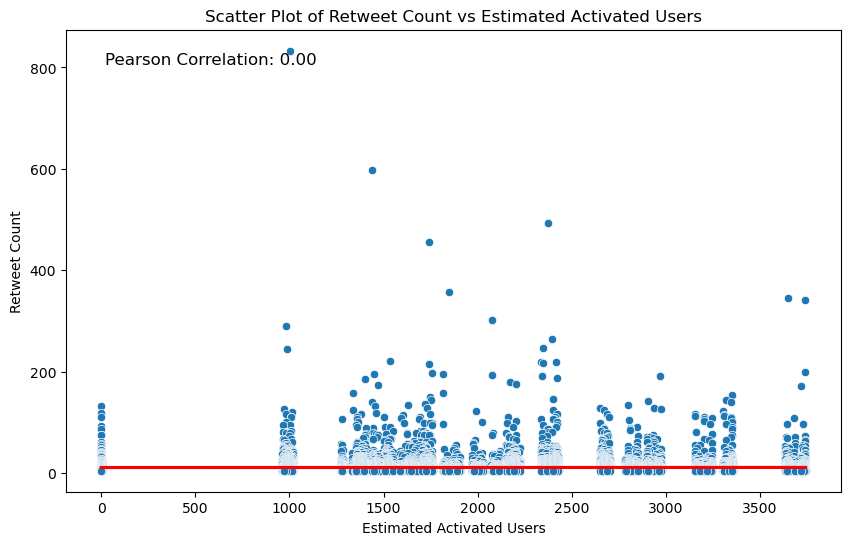

In [86]:
filtered_retweets = pd.read_csv(f'/mnt/nas/minici/SocialAIGym/notebooks/retweet2BCM_eps{0.2}.csv', lineterminator='\n', index_col=0) 
epsilon2numActivated = {0.2: filtered_retweets}
print(filtered_retweets.head())

for epsilon in [0.2]:  # [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]:
    filtered_retweets = epsilon2numActivated[epsilon].copy()
    # Drop rows with missing estimated activated users
    filtered_retweets = filtered_retweets.dropna(subset=['estimated_activated_users'])
    # FILTER=False
    # if FILTER:
    #     rt_top_percentile_val = 150# np.percentile(filtered_retweets['retweet_count'], 99)
    #     estimated_active_top_percentile_val = 1000# np.percentile(filtered_retweets['estimated_activated_users'], 50)
    #     filtered_retweets = filtered_retweets[filtered_retweets['retweet_count'] > rt_top_percentile_val]
        # filtered_retweets = filtered_retweets[filtered_retweets['estimated_activated_users'] > estimated_active_top_percentile_val]
    
    from scipy.stats import pearsonr
    
    # Compute the correlation
    correlation, p_value = pearsonr(filtered_retweets['estimated_activated_users'], filtered_retweets['retweet_count'])
    
    print(f'Correlation between number of retweets and estimated number of activated users: {correlation}')
    print(f'P-value: {p_value}')

    import seaborn as sns
    
    # Plot scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(x='estimated_activated_users', 
            y='retweet_count', data=filtered_retweets, scatter_kws={'s': 10}, line_kws={'color': 'red'},
            scatter=False)
    sns.scatterplot(x='estimated_activated_users', 
            y='retweet_count', data=filtered_retweets,)
            # size='stance', alpha=0.7)
    plt.xlabel('Estimated Activated Users')
    plt.ylabel('Retweet Count')
    plt.title('Scatter Plot of Retweet Count vs Estimated Activated Users')
    
    # Display correlation on plot
    plt.text(0.05, 0.95, f'Pearson Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')




## Display results with standard regression by restricting to real tweets with more than 200 retweets

Correlation between number of retweets and estimated number of activated users: -0.2649922073369791
P-value: 0.3039998308798517


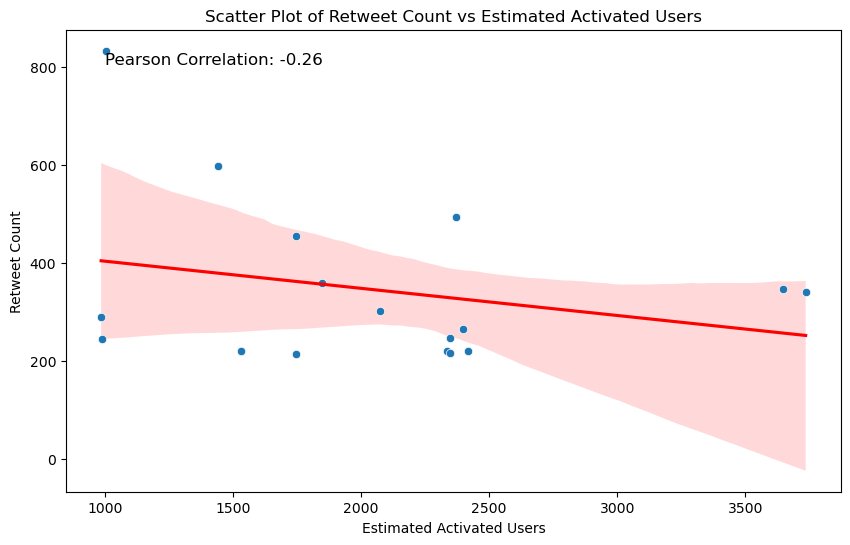

In [87]:
for epsilon in [0.2]:  # [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]:
    filtered_retweets = epsilon2numActivated[epsilon].copy()
    # Drop rows with missing estimated activated users
    filtered_retweets = filtered_retweets.dropna(subset=['estimated_activated_users'])
    FILTER=True
    if FILTER:
        rt_top_percentile_val = 200# np.percentile(filtered_retweets['retweet_count'], 99)
        estimated_active_top_percentile_val = 1000# np.percentile(filtered_retweets['estimated_activated_users'], 50)
        filtered_retweets = filtered_retweets[filtered_retweets['retweet_count'] > rt_top_percentile_val]
        # filtered_retweets = filtered_retweets[filtered_retweets['estimated_activated_users'] > estimated_active_top_percentile_val]
    
    from scipy.stats import pearsonr
    
    # Compute the correlation
    correlation, p_value = pearsonr(filtered_retweets['estimated_activated_users'], filtered_retweets['retweet_count'])
    
    print(f'Correlation between number of retweets and estimated number of activated users: {correlation}')
    print(f'P-value: {p_value}')

    import seaborn as sns
    
    # Plot scatter plot with regression line
    plt.figure(figsize=(10, 6))
    sns.regplot(x='estimated_activated_users', 
            y='retweet_count', data=filtered_retweets, scatter_kws={'s': 10}, line_kws={'color': 'red'},
            scatter=False)
    sns.scatterplot(x='estimated_activated_users', 
            y='retweet_count', data=filtered_retweets,)
            # size='stance', alpha=0.7)
    plt.xlabel('Estimated Activated Users')
    plt.ylabel('Retweet Count')
    plt.title('Scatter Plot of Retweet Count vs Estimated Activated Users')
    
    # Display correlation on plot
    plt.text(0.05, 0.95, f'Pearson Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')




## Display results with Robust Regression (RANSAC) and restricting to tweets with more than 200 retweets

/home/minici/anaconda3/envs/socLLM/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/minici/anaconda3/envs/socLLM/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/minici/anaconda3/envs/socLLM/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


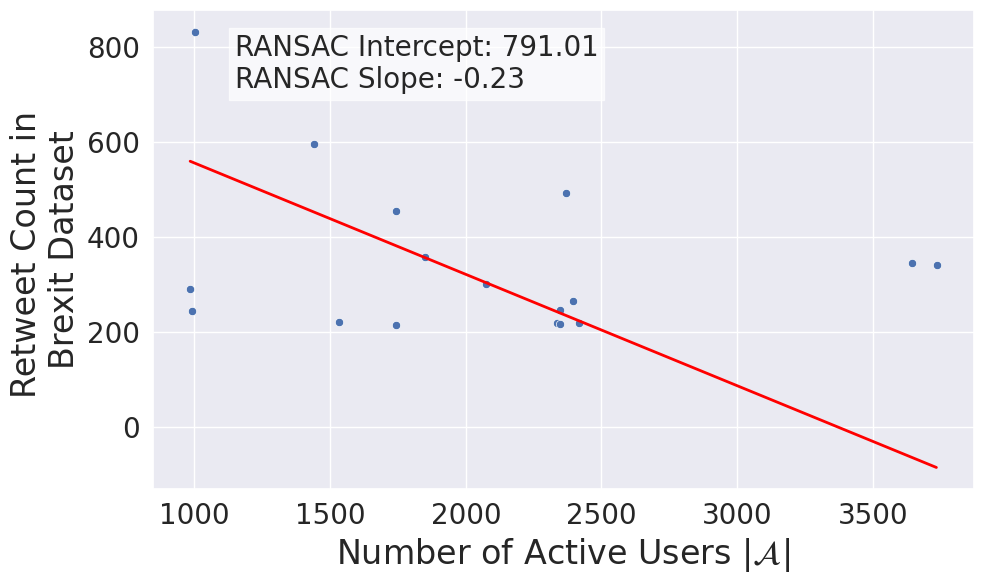

In [88]:
from sklearn.linear_model import RANSACRegressor, LinearRegression

for epsilon in [0.2]:  # [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]:
    filtered_retweets = epsilon2numActivated[epsilon].copy()
    # Drop rows with missing estimated activated users
    filtered_retweets = filtered_retweets.dropna(subset=['estimated_activated_users'])
    FILTER=True
    if FILTER:
        rt_top_percentile_val = 200# np.percentile(filtered_retweets['retweet_count'], 99)
        estimated_active_top_percentile_val = 1000# np.percentile(filtered_retweets['estimated_activated_users'], 50)
        filtered_retweets = filtered_retweets[filtered_retweets['retweet_count'] > rt_top_percentile_val]
        # filtered_retweets = filtered_retweets[filtered_retweets['estimated_activated_users'] > estimated_active_top_percentile_val]
    
    from scipy.stats import pearsonr
    
    # Compute the correlation
    # correlation, p_value = pearsonr(filtered_retweets['estimated_activated_users'], filtered_retweets['retweet_count'])
    
    # print(f'Correlation between number of retweets and estimated number of activated users: {correlation}')
    # print(f'P-value: {p_value}')

    import seaborn as sns
    sns.set()
    # Plot scatter plot with regression line
    plt.figure(figsize=(10, 6))
    # sns.regplot(x='estimated_activated_users', 
    #         y='retweet_count', data=filtered_retweets, scatter_kws={'s': 10}, line_kws={'color': 'red'},
    #         scatter=False)
    sns.scatterplot(x='estimated_activated_users', 
            y='retweet_count', data=filtered_retweets,)
            # size='stance', alpha=0.7)
    # Fit RANSAC regressor
    ransac = RANSACRegressor(LinearRegression(), min_samples=5, residual_threshold=10.0, random_state=0)
    # ransac = RANSACRegressor(LinearRegression())
    X, y = filtered_retweets['estimated_activated_users'].values.reshape(-1, 1), filtered_retweets['retweet_count'].values.reshape(-1, 1)
    ransac.fit(X, y)
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    plt.plot(line_X, line_y_ransac, color='red', linewidth=2, label='RANSAC regression')
    plt.xlabel(r'Number of Active Users $|\mathcal{A}|$', fontsize=24)
    plt.ylabel('Retweet Count in \nBrexit Dataset', fontsize=24)
    # plt.title('Scatter Plot of Retweet Count vs Estimated Activated Users')
    
    # Display correlation on plot
    # plt.text(0.05, 0.95, f'Pearson Correlation: {correlation:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    # Extract the intercept and slope (angular coefficient)
    intercept = ransac.estimator_.intercept_[0]
    slope = ransac.estimator_.coef_[0, 0]
    # Display Regression line coefficients for Robust Regression
    plt.text(0.1, 0.95, f'RANSAC Intercept: {intercept:.2f}\nRANSAC Slope: {slope:.2f}',
             transform=plt.gca().transAxes, fontsize=20, verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.savefig(f'/mnt/nas/minici/SocialAIGym/notebooks/retweet2BCM_RANSAC_line{0.2}.pdf')
    